In [2]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)


In [3]:
import pandas as pd
import numpy as np
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from src.io_utils import load_df
from src.config import COLS, SEED
from src.eval_utils import compute_metrics, save_json, plot_confusion
import matplotlib.pyplot as plt


In [4]:
X_TRAIN_PATH  = os.path.join(PROJECT_ROOT, "data/processed/X_train.csv")
Y_TRAIN_PATH  = os.path.join(PROJECT_ROOT, "data/processed/y_train.csv")
X_TEST_PATH   = os.path.join(PROJECT_ROOT, "data/processed/X_test.csv")
Y_TEST_PATH   = os.path.join(PROJECT_ROOT, "data/processed/y_test.csv")

MODEL_PATH    = os.path.join(PROJECT_ROOT, "models/rf_baseline.pkl")
REPORTS_JSON  = os.path.join(PROJECT_ROOT, "reports/rf_metrics.json")
FIG_CM_RAW    = os.path.join(PROJECT_ROOT, "figures/rf_confusion_raw.png")
FIG_CM_NORM   = os.path.join(PROJECT_ROOT, "figures/rf_confusion_norm.png")
FIG_FEAT_IMP  = os.path.join(PROJECT_ROOT, "figures/rf_feature_importance.png")


In [5]:
X_train = load_df(X_TRAIN_PATH)
y_train = load_df(Y_TRAIN_PATH)["Target"]
X_test  = load_df(X_TEST_PATH)
y_test  = load_df(Y_TEST_PATH)["Target"]

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train class ratio:\n", y_train.value_counts(normalize=True).round(3))
print("Test  class ratio:\n", y_test.value_counts(normalize=True).round(3))


Train: (3539, 13)  Test: (885, 13)
Train class ratio:
 Target
2    0.499
0    0.321
1    0.179
Name: proportion, dtype: float64
Test  class ratio:
 Target
2    0.499
0    0.321
1    0.180
Name: proportion, dtype: float64


In [6]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)
rf.fit(X_train, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,20
,min_samples_split,4
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
y_pred = rf.predict(X_test)

label_names = ["Dropout", "Graduate", "Enrolled"]  # ensure this matches your label encoding order
labels = sorted(y_train.unique())

metrics = compute_metrics(y_test, y_pred, labels=labels, label_names=label_names)
print("Accuracy:", round(metrics["accuracy"], 4))
print(pd.DataFrame(metrics["per_class"]).T)

save_json(metrics, REPORTS_JSON)
print("Saved metrics ->", REPORTS_JSON)


Accuracy: 0.7458
          precision    recall        f1  support
Dropout    0.788462  0.721831  0.753676    284.0
Graduate   0.443243  0.515723  0.476744    159.0
Enrolled   0.847727  0.843891  0.845805    442.0
Saved metrics -> /home/glinux/Projects/Skole/AnvendtData/reports/rf_metrics.json


Saved confusion matrices -> /home/glinux/Projects/Skole/AnvendtData/figures/rf_confusion_raw.png  &  /home/glinux/Projects/Skole/AnvendtData/figures/rf_confusion_norm.png


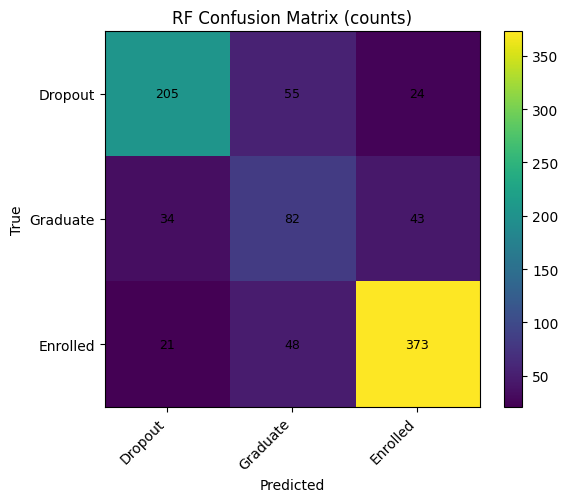

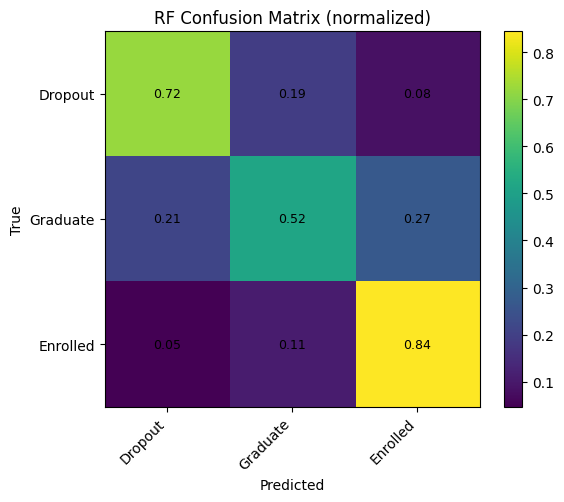

In [8]:
plot_confusion(y_test, y_pred, label_names=label_names, normalize=False,
               title="RF Confusion Matrix (counts)", save_path=FIG_CM_RAW)
plot_confusion(y_test, y_pred, label_names=label_names, normalize=True,
               title="RF Confusion Matrix (normalized)", save_path=FIG_CM_NORM)
print("Saved confusion matrices ->", FIG_CM_RAW, " & ", FIG_CM_NORM)


In [9]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top = importances.head(15)

plt.figure(figsize=(7, 5))
top.iloc[::-1].plot(kind='barh')
plt.title("Random Forest — Top Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(FIG_FEAT_IMP, dpi=150, bbox_inches='tight')
plt.close()
print("Saved feature importance ->", FIG_FEAT_IMP)

from joblib import dump
dump(rf, MODEL_PATH)
print("Saved model ->", MODEL_PATH)


Saved feature importance -> /home/glinux/Projects/Skole/AnvendtData/figures/rf_feature_importance.png
Saved model -> /home/glinux/Projects/Skole/AnvendtData/models/rf_baseline.pkl
